In [1]:
import os
import pandas as pd
import numpy as np
from io import StringIO

# 데이터 전처리

In [2]:
file_dir = './태양풍/'
file_names = [f'ace_{year}.csv' for year in range(1999, 2014)]

In [3]:
# 모든 파일을 읽어와서 데이터프레임 리스트에 저장
ace_data_list = [] # 비어있는 데이터 프레임 리스트 만들기
for file_name in file_names: # file_name 하나씩 조회
    file_path = os.path.join(file_dir, file_name) # file_dir랑 file_name 합쳐서 path 생성
    with open(file_path, 'r') as file: # read 모드로 열기
        lines = file.readlines() # 라인 읽어오기
        data_started = False 
        data_lines = [] # 비어있는 data_lines 생성
        for line in lines: # 읽은 라인들 하나씩 조회
            if "BEGIN DATA" in line: # 데이터 설명하는 row들이 끝나면
                data_started = True # data_started를 true로 바꿈
                continue
            if data_started: # data_started 이면 
                data_lines.append(line) # 라인 읽어서 data_lines에 붙이기
        # data_lines 리스트에 저장된 데이터를 데이터프레임으로 변환
        ace_data = pd.read_csv(StringIO('\n'.join(data_lines)), delim_whitespace=True, names=['year', 'doy', 'hr', 'min', 'Np', 'Tp', 'Vp', 'B_gsm_x', 'B_gsm_y', 'B_gsm_z', 'Bt'])
        # year, doy, hr, min 열을 하나의 datetime 형식으로 변환
        ace_data['datetime'] = pd.to_datetime(ace_data['year'].astype(str) + '-' + ace_data['doy'].astype(str) + ' ' + ace_data['hr'].astype(str) + ':' + ace_data['min'].astype(str), format='%Y-%j %H:%M')
        # 데이터프레임의 인덱스를 datetime 열로 설정
        ace_data = ace_data.set_index('datetime')
        # 특정 값들을 실제 결측값(NaN)으로 대체
        ace_data.replace([-9999.900, -9.9999e+03, -9999.90, -9999.9004], np.nan, inplace=True)
        # 전처리가 완료된 데이터프레임을 리스트에 추가
        ace_data_list.append(ace_data)

/var/folders/jq/ghsw3hz1139068l6f7s904y40000gn/T/ipykernel_27775/785987786.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ace_data = pd.read_csv(StringIO('\n'.join(data_lines)), delim_whitespace=True, names=['year', 'doy', 'hr', 'min', 'Np', 'Tp', 'Vp', 'B_gsm_x', 'B_gsm_y', 'B_gsm_z', 'Bt'])
/var/folders/jq/ghsw3hz1139068l6f7s904y40000gn/T/ipykernel_27775/785987786.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ace_data = pd.read_csv(StringIO('\n'.join(data_lines)), delim_whitespace=True, names=['year', 'doy', 'hr', 'min', 'Np', 'Tp', 'Vp', 'B_gsm_x', 'B_gsm_y', 'B_gsm_z', 'Bt'])
/var/folders/jq/ghsw3hz1139068l6f7s904y40000gn/T/ipykernel_27775/785987786.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``

In [4]:
# 모든 데이터프레임을 하나로 결합
ace_data_combined = pd.concat(ace_data_list)

In [5]:
def calculate_statistics(group):
    return pd.Series({
        'Np_min': group['Np'].min(),
        'Np_max': group['Np'].max(),
        'Np_mean': group['Np'].mean(),
        'Np_std': group['Np'].std(),
        'Np_median': group['Np'].median(),
        'Tp_min': group['Tp'].min(),
        'Tp_max': group['Tp'].max(),
        'Tp_mean': group['Tp'].mean(),
        'Tp_std': group['Tp'].std(),
        'Tp_median': group['Tp'].median(),
        'Vp_min': group['Vp'].min(),
        'Vp_max': group['Vp'].max(),
        'Vp_mean': group['Vp'].mean(),
        'Vp_std': group['Vp'].std(),
        'Vp_median': group['Vp'].median(),
        'B_gsm_x_min': group['B_gsm_x'].min(),
        'B_gsm_x_max': group['B_gsm_x'].max(),
        'B_gsm_x_mean': group['B_gsm_x'].mean(),
        'B_gsm_x_std': group['B_gsm_x'].std(),
        'B_gsm_x_median': group['B_gsm_x'].median(),
        'B_gsm_y_min': group['B_gsm_y'].min(),
        'B_gsm_y_max': group['B_gsm_y'].max(),
        'B_gsm_y_mean': group['B_gsm_y'].mean(),
        'B_gsm_y_std': group['B_gsm_y'].std(),
        'B_gsm_y_median': group['B_gsm_y'].median(),
        'B_gsm_z_min': group['B_gsm_z'].min(),
        'B_gsm_z_max': group['B_gsm_z'].max(),
        'B_gsm_z_mean': group['B_gsm_z'].mean(),
        'B_gsm_z_std': group['B_gsm_z'].std(),
        'B_gsm_z_median': group['B_gsm_z'].median(),
        'Bt_min': group['Bt'].min(),
        'Bt_max': group['Bt'].max(),
        'Bt_mean': group['Bt'].mean(),
        'Bt_std': group['Bt'].std(),
        'Bt_median': group['Bt'].median()
    })


In [6]:
from scipy.stats import norm

# 결측값이 아닌 데이터의 분포 추정
def estimate_distribution(column):
    non_na_data = column.dropna()
    mu, std = norm.fit(non_na_data)
    return mu, std

# 결측값을 추정된 분포에서 샘플링한 값으로 대체
def fill_missing_with_distribution(df):
    filled_df = df.copy() # 받은 데이터 복사본 만들기
    for column in df.columns: # column 하나씩 조회
        mu, std = estimate_distribution(df[column]) # 평균, 표준편차 구하기
        missing_mask = df[column].isna() # 결측치의 위치 표시
        filled_values = norm.rvs(loc=mu, scale=std, size=missing_mask.sum()) # 추정된 분포에서 샘플링
        filled_df.loc[missing_mask, column] = filled_values # 채워 넣기
    return filled_df

In [7]:
# 3시간 단위로 리샘플링해서 calculate_statistics 함수 적용
ace_resampled_combined = ace_data_combined.resample('3H').apply(calculate_statistics)

/var/folders/jq/ghsw3hz1139068l6f7s904y40000gn/T/ipykernel_27775/425979237.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ace_resampled_combined = ace_data_combined.resample('3H').apply(calculate_statistics)


In [8]:
# ace_resampled_combined.to_csv('./pp_ace.csv')

In [9]:
# 지자기 교란 지수 데이터 불러오기 및 전처리
geomagnetic_data = pd.read_csv('./지자기교란 지수.csv')

# 'date' 열을 datetime 형식으로 변환
geomagnetic_data['date'] = pd.to_datetime(geomagnetic_data['date'])

In [10]:
# 지자기 교란 지수를 3시간 간격으로 전환
geomagnetic_long = geomagnetic_data.melt(id_vars=['date'], var_name='hour', value_name='Kp')
geomagnetic_long['hour'] = geomagnetic_long['hour'].str.extract('(\d+)').astype(int)
geomagnetic_long['datetime'] = geomagnetic_long.apply(lambda row: row['date'] + pd.Timedelta(hours=row['hour']), axis=1)

# datetime을 index로 사용
geomagnetic_long = geomagnetic_long.set_index('datetime')
# datetime 기준으로 sort
geomagnetic_long.sort_values(by='datetime', inplace=True)

#geomagnetic_long.to_csv('geomagnetic_long.csv')

In [11]:
# 필요한 열(지자기교란 지수 값)만 선택
geomagnetic_long = geomagnetic_long[['Kp']]
geomagnetic_long = geomagnetic_long.iloc[1:]

# ace_resampled_combined의 값을 한 칸씩 뒤로 밀기
ace_resampled_combined_shifted = ace_resampled_combined.shift(1)
ace_resampled_combined_shifted = ace_resampled_combined_shifted.iloc[1:]

# 데이터 병합
merged_ace_kp_data = ace_resampled_combined_shifted.join(geomagnetic_long, how='inner')

# 결과 출력
#print(merged_ace_kp_data.head)  # 처음 24개의 데이터를 출력하여 확인
print(merged_ace_kp_data.shape)
#merged_ace_kp_data.to_csv('./merged_ace_kp_data_.csv')

(43831, 36)


In [12]:
# X_data와 Y_data로 분할
X_data = merged_ace_kp_data.drop(columns=['Kp'])
Y_data = merged_ace_kp_data[['Kp']]

#print(X_data.shape)
#print(Y_data.shape)

# 데이터 분할

In [13]:
# 2013년 데이터와 그 외 데이터로 분할
train_X_data = X_data[X_data.index.year < 2013]
test_X_data = X_data[X_data.index.year == 2013]

train_Y_data = Y_data[Y_data.index.year < 2013]
test_Y_data = Y_data[Y_data.index.year == 2013]

# 전처리 데이터 추출

In [14]:
# 데이터 분할 확인
print("Train X_data shape:", train_X_data.shape)
print("Test X_data shape:", test_X_data.shape)
print("Train Y_data shape:", train_Y_data.shape)
print("Test Y_data shape:", test_Y_data.shape)

Train X_data shape: (40911, 35)
Test X_data shape: (2920, 35)
Train Y_data shape: (40911, 1)
Test Y_data shape: (2920, 1)


In [15]:
# 분할된 데이터 저장
train_X_data.to_csv('./train_set/train_X_data_nan.csv')
test_X_data.to_csv('./test_set/test_X_data_nan.csv')
train_Y_data.to_csv('./train_set/train_Y_data.csv')
test_Y_data.to_csv('./test_set/test_Y_data.csv')

# 데이터 시각화

In [16]:
import matplotlib.pyplot as plt

In [17]:
# 이동 평균 계산
rolling_avg = train_Y_data.rolling(window=8).mean()
# 이동 표준편차 계산
rolling_std = train_Y_data.rolling(window=8).std()

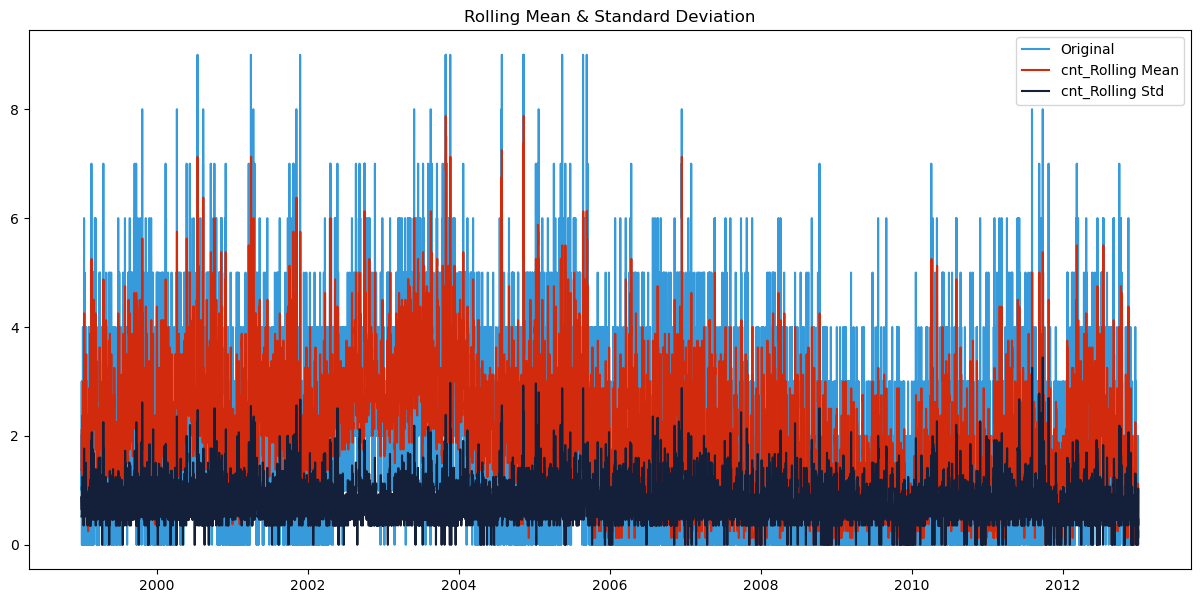

In [18]:
#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(train_Y_data, color='#379BDB', label='Original') # train data
plt.plot(rolling_avg, color='#D22A0D', label='cnt_Rolling Mean') # mean
plt.plot(rolling_std, color='#142039', label='cnt_Rolling Std') # std
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)